In [30]:
# Manejo de archivos
import os
from pathlib import Path

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#outliers 
from pyod.models.mcd import MCD

#
import ipywidgets as widget

from datetime import datetime, timedelta, time, date

In [8]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
raw_folder = Path.cwd().parent / 'data' / 'raw'

In [11]:
df_raw = pd.read_parquet(raw_folder / "df_model.parquet")
df_vel_fixed =  df_raw[df_raw.velocidad >74.22].copy() #40% de los datos estan por encima del 74.22 y 77

Para detectar outliers se usara el modelo MCD del modulo pyod.models. Este se a usado con anterioridad en estos mismos datos con resultados satisfactorios. Además de detectar outliers ayuda a filtrar modos de operación poco frecuentes.

In [43]:
mcd_model = MCD(contamination  = 0.01) #se probaron entre 0.1 y 0.5
vars_outliers = ['velocidad',
                'potencia',
                'flujo_agua',
                'rendimiento',
                'presion_ewm']
mcd_model.fit(df_raw[vars_outliers])
df_raw['outlier'] = mcd_model.labels_
df_vel_fixed['outlier'] = df_raw['outlier'] #funciona por ser indice datetime

<Axes: xlabel='presion_ewm', ylabel='potencia'>

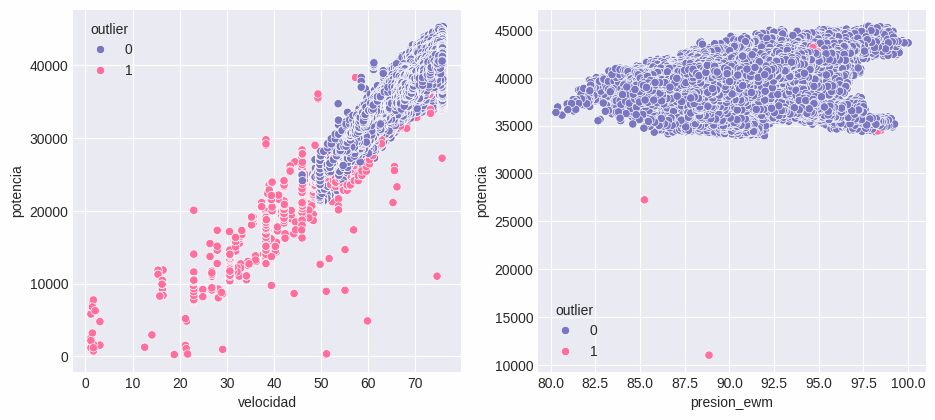

In [44]:
fig, axs = plt.subplots(1, 2, figsize = (11, 4.7))
sns.scatterplot(x = 'velocidad',
              y = 'potencia',
                hue = 'outlier',
             data = df_raw,
               ax = axs[0])

sns.scatterplot(x = 'presion_ewm',
              y = 'potencia',
             hue = 'outlier',
             data = df_vel_fixed,
               ax = axs[1])

Al utilizar el modelo MCD para detectar outliers se eliminan los modos de operación extremos (debajo del 50% de velocidad) junto con valores que claramente fueron erroneamente medidos por los sensores. Estos es conveniente ya que esos datos son raramente usados en operacion y no deberían ser tomados en cuenta para el desarrollo de algún modelo.

In [45]:
df_raw.groupby('outlier')['per_solidos'].agg(['min', lambda x: x.quantile(0.1),'median', 'mean', 'max'])

,min,<lambda_0>,median,mean,max
outlier,,,,,
0,20.87549,69.867190,75.730470,75.070372,84.21094
1,-111.73050,-0.488296,74.291995,55.851540,133.49610


La variable porcentaje de solidos se calcula en base a las variables rendimiento y flujo de agua,en muy raras ocaciones se encuntra por debajo del 60% y solo baja cuando el molino se encuentra en proceso de vaciado. Por misma definición de esta variables no debe tomar valores negativos ni valores mayores a 100.

Al igual que el caso anterior, no es conveniente tomar en cuanta los valores extremos y aún menos los que son negativos o mayores a 100.

In [46]:
def graf_series(dia):
    ini = datetime.combine(dia, time(0, 0, 0))
    fin = ini + timedelta(days = 1)
    view = df_raw.loc[ini:fin]

    vars_to_plot = ['potencia', 'velocidad', 'presion_ewm', 'per_solidos', 'f80']
    fig, axs = plt.subplots(len(vars_to_plot), 1, figsize = (13, 15))
    for v, ax in zip(vars_to_plot, axs):
        sns.scatterplot(x = 'date',
                     y = v,
                        hue = 'outlier',
                        linewidth = 0,
                        s = 5,
                    ax = ax,
                    data = view.reset_index())
widget.interact(graf_series, dia = df_raw.reset_index().date.dt.date.unique())

interactive(children=(Dropdown(description='dia', options=(datetime.date(2022, 11, 15), datetime.date(2022, 11…

<function __main__.graf_series(dia)>

Dias interesantes:
* 23 de noviembre
* 26 de noviembre
* 28 de noviembre
* 29 de noviembre
* 11 de diciembre